In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch.nn.functional as F
import torch.nn.init as init
import shap

In [2]:
with open('data/merged_data.csv') as x:
    ncols = len(x.readline().split(','))
merged_data = pd.read_csv('data/merged_data.csv', usecols=range(1,ncols))

In [3]:
merged_data

,year,round,name,grid,positionOrder,points,laps,milliseconds,fastestLap,rank,...,position_qualifying,points_constructorResults,points_constructorStandings,position_constructorStandings,wins,month_sin,month_cos,day_sin,day_cos,day_of_week_sin
0,2009,1,3.0,1.0,1,10.0,58.0,5655784.0,17.0,3.0,...,1.0,18.0,18.0,1.0,1.0,1.000000,6.123234e-17,-0.394356,0.918958,-0.781832
1,2009,1,3.0,1.0,1,10.0,58.0,5655784.0,17.0,3.0,...,1.0,18.0,25.0,1.0,2.0,1.000000,6.123234e-17,-0.394356,0.918958,-0.781832
2,2009,1,3.0,1.0,1,10.0,58.0,5655784.0,17.0,3.0,...,1.0,18.0,36.0,1.0,2.0,1.000000,6.123234e-17,-0.394356,0.918958,-0.781832
3,2009,1,3.0,1.0,1,10.0,58.0,5655784.0,17.0,3.0,...,1.0,18.0,50.0,1.0,3.0,1.000000,6.123234e-17,-0.394356,0.918958,-0.781832
4,2009,1,3.0,1.0,1,10.0,58.0,5655784.0,17.0,3.0,...,1.0,18.0,68.0,1.0,4.0,1.000000,6.123234e-17,-0.394356,0.918958,-0.781832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523628,2023,18,52.0,35.0,40,0.0,0.0,15090541.0,-1.0,25.0,...,-1.0,0.0,0.0,23.0,0.0,-0.866025,5.000000e-01,-0.968077,-0.250653,-0.781832
9523629,2023,19,31.0,35.0,40,0.0,0.0,15090541.0,-1.0,25.0,...,-1.0,0.0,0.0,23.0,0.0,-0.866025,5.000000e-01,-0.394356,0.918958,-0.781832
9523630,2023,20,49.0,35.0,40,0.0,0.0,15090541.0,-1.0,25.0,...,-1.0,0.0,0.0,23.0,0.0,-0.500000,8.660254e-01,0.848644,0.528964,-0.781832
9523631,2023,21,27.0,35.0,40,0.0,0.0,15090541.0,-1.0,25.0,...,-1.0,0.0,0.0,23.0,0.0,-0.500000,8.660254e-01,-0.651373,-0.758758,-0.781832


#### Data Preparing

In [4]:
X = merged_data.drop(['positionOrder'], axis=1)
y = merged_data['positionOrder']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005, random_state=42)

# Normalize X
scaler = StandardScaler()
features_to_scale = X_train.columns.difference(['year', 'round'])
X_to_scale = X_train[features_to_scale]
X_train_scaled = scaler.fit_transform(X_to_scale)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features_to_scale)
X_train_scaled[['year', 'round']] = X_train[['year', 'round']].reset_index(drop=True)

X_test_scaled = scaler.transform(X_test[features_to_scale])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features_to_scale)
X_test_scaled[['year', 'round']] = X_test[['year', 'round']].reset_index(drop=True)

# Convert to tensors
X_train = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for batch processing
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

In [5]:
len(X_train)

9476014

In [6]:
len(X_test)

47619

In [7]:
len(train_loader)

148063

#### Model Definition

In [8]:
class CNN(nn.Module):
    def __init__(self, num_features):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * (num_features // 2 // 2), 512) # Flatten after two pooling layers
        self.fc2 = nn.Linear(512, 256) 
        self.fc3 = nn.Linear(256, 1)# Output layer for regression

    def forward(self, x):
        # Convolutional layers expect input of size (N, C, L) where
        # N is batch size, C is number of channels, and L is length of the signal.
        # Since we're dealing with tabular data, we'll treat each row as a "channel"
        x = x.unsqueeze(1)  # Add a channel dimension (N, L) -> (N, C, L)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        # Flatten the tensor so we can feed it into the dense layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn_model = CNN(num_features=X_train.shape[1])
print(cnn_model)

# Training Loop
def train(model, epochs=5, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_epoch_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_epoch_loss}")

CNN(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=448, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


In [106]:
# Train the CNN
train(cnn_model)

Epoch 1/5 Loss: 1.202265078212319
Epoch 2/5 Loss: 0.20825177142539542
Epoch 3/5 Loss: 0.1396608668533359
Epoch 4/5 Loss: 0.11444892386369301
Epoch 5/5 Loss: 0.10205352799150547


In [107]:
# Save the CNN model's state dictionary
torch.save(cnn_model.state_dict(), 'cnn_model.pth')

In [9]:
cnn_model = CNN(num_features=X_train.shape[1])
cnn_model.load_state_dict(torch.load('cnn_model.pth'))

<All keys matched successfully>

In [10]:
def compute_rmse(y_pred, y_true):
    return torch.sqrt(torch.mean((y_pred - y_true)**2))

# Predict on the test set
cnn_model.eval()
with torch.no_grad():
    predictions = cnn_model(X_test)

rmse = compute_rmse(predictions.squeeze(), y_test)
print(f"CNN Model RMSE: {rmse.item()}")

CNN Model RMSE: 0.3176287114620209


#### Model Interpretation

In [13]:
# Using a part of training data for creating background distribution for shap
background = shap.utils.sample(X_train, 100)
X_test_numpy = X_test.numpy()
cnn_model.eval()

# Define a wrapper function for the model's prediction
def cnn_predict(data_as_numpy):
    data_as_tensor = torch.from_numpy(data_as_numpy).float()
    with torch.no_grad():
        predictions = cnn_model(data_as_tensor)
    return predictions.numpy()

# Initialize the SHAP explainer with the background data and the prediction function
cnn_explainer = shap.KernelExplainer(model=cnn_predict, data=background.numpy())

# Calculate SHAP values for the test dataset
cnn_shap_values = cnn_explainer.shap_values(X=X_test_numpy[:50])

  0%|          | 0/50 [00:00<?, ?it/s]

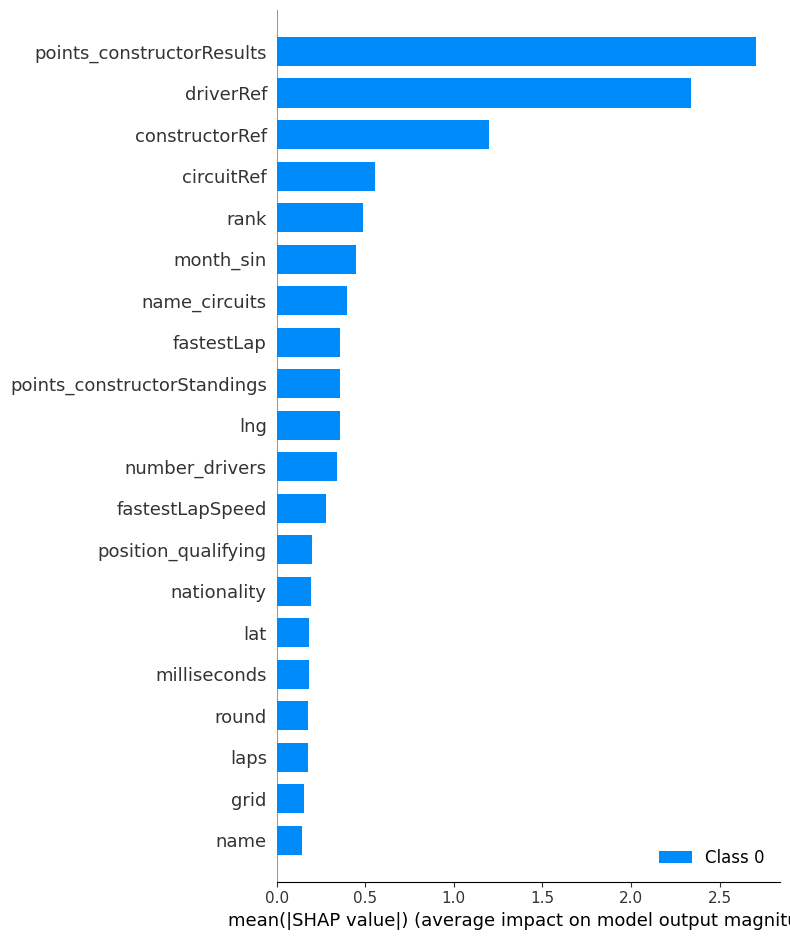

In [15]:
# Summary plot
shap.summary_plot(cnn_shap_values, X_test_numpy[:50], feature_names=X.columns)

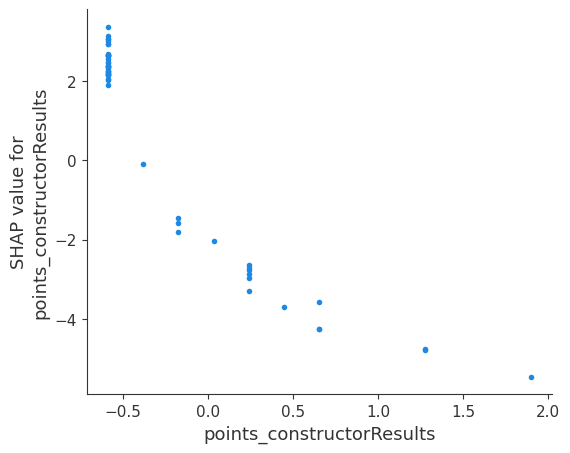

In [16]:
# Dependence plot for single feature points_constructorResults, which has major contribution to the predictions
shap.dependence_plot('points_constructorResults', cnn_shap_values[0], X_test_numpy[:50], feature_names=X.columns, interaction_index=None)

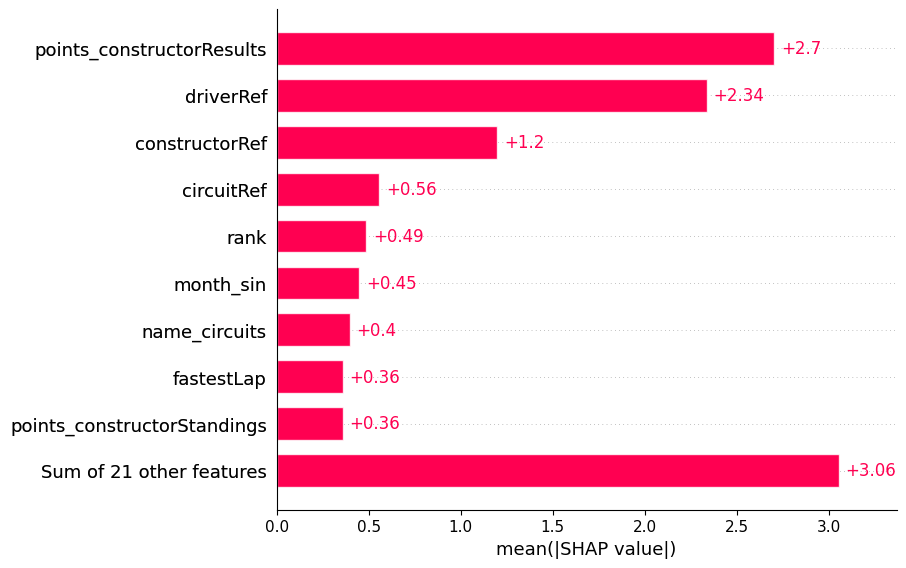

In [17]:
# Bar plot - creating an Explanation object from the SHAP values
shap_values = np.array(cnn_shap_values[0])
expl = shap.Explanation(values=shap_values, data=X_test_numpy[:50], feature_names=X.columns)
shap.plots.bar(expl)

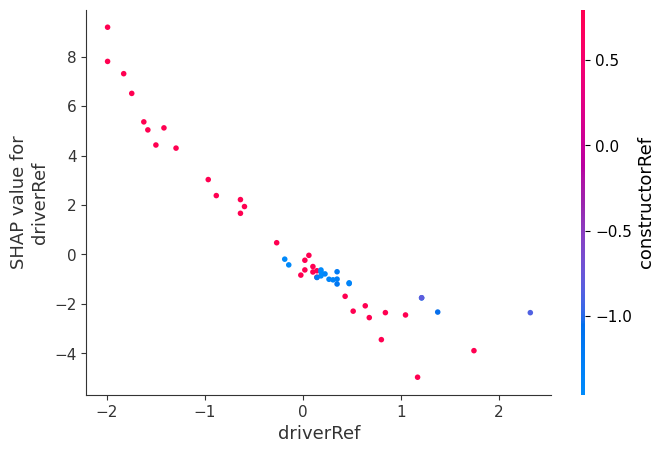

In [18]:
# Interaction plot - between features constructorRef and driverRef
shap.dependence_plot('driverRef', cnn_shap_values[0], X_test_numpy[:50], feature_names=X.columns, interaction_index='constructorRef')